# Assignment 3: K-Means Clustering (15pts)

In this homework, we will explore how the K-Nearest-Neighbour matching works.

## Conda Setup

Generate the conda environment by running in the terminal:

`conda create --name gcv_exercise_3 python=3.11`

Run to activate environment:

`conda activate gcv_exercise_3`

Install all required packages for this exercise by running:

`conda install matplotlib numpy scikit-image scikit-learn`

Install Jupyter Notebook requirements:

`conda install -n gcv_exercise_3 ipykernel --update-deps --force-reinstall`

(Optional) If you are working on the TUWEL Juypter Notebooks:

`ipython kernel install --name "GCV_E_3" --user`

## Notebook Setup & Imports

In [2]:
# Setup

import numpy as np
from time import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import pickle


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for reproducibility
np.random.seed(42)


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: K-Means Clustering & Evaluation (10 Pts)

### 1.1: K-Means Clustering (8pts)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the `kmeans()`-function. Your task is to finish the implementation. We also provide you with a blob-dataset, that contains 1000 objects for 5 classes.

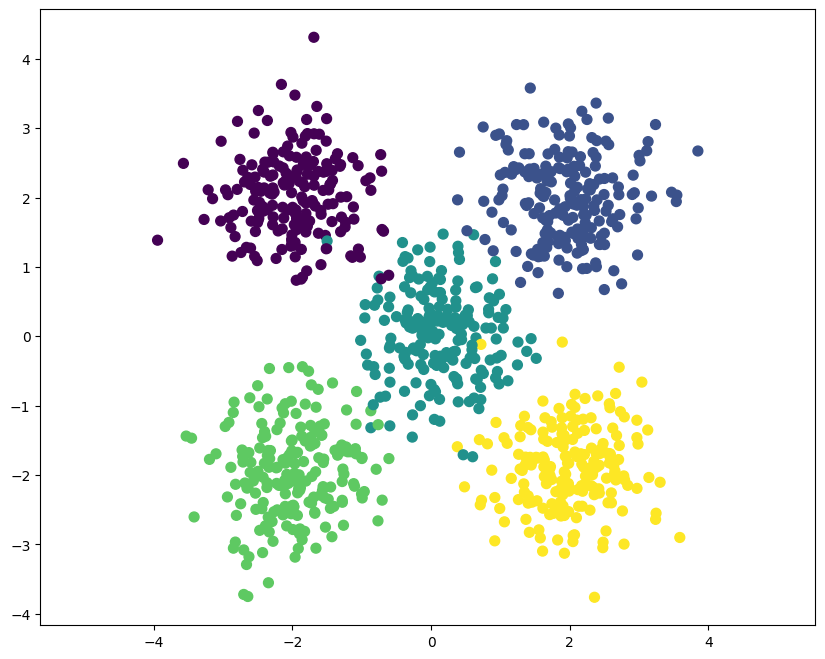

In [3]:
# Generate random data points for clustering
n_samples = 1000
centers = [[-2, 2], [2, 2], [0, 0], [-2, -2], [2, -2]]
std = 0.6

X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=std, random_state=42)

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.axis('equal')
plt.show()

In [4]:
def kmeans(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    K-Means algorithm can be broken down into following steps:
        1. Randomly initialize cluster centers
        2. Assign each point to the closest center
        3. Compute new center of each cluster
        4. Stop if cluster assignments did not change
        5. Go to step 2
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N, dtype=np.uint32)

    for n in range(num_iters):
        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****

        # calculate distances from each point to each center
        distances = np.zeros((N, k))
        for i in range(k):
            distances[:, i] = np.linalg.norm(features - centers[i], axis=1)
        
        # assign each point to nearest center
        new_assignments = np.argmin(distances, axis=1)
        
        # check if assignments changed
        if np.all(assignments == new_assignments):
            break
        
        assignments = new_assignments
        
        # compute new centers for each cluster
        for i in range(k):
            cluster_points = features[assignments == i]
            if len(cluster_points) > 0:
                centers[i] = np.mean(cluster_points, axis=0)
            
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    return assignments

kmeans running time: 0.000000 seconds.


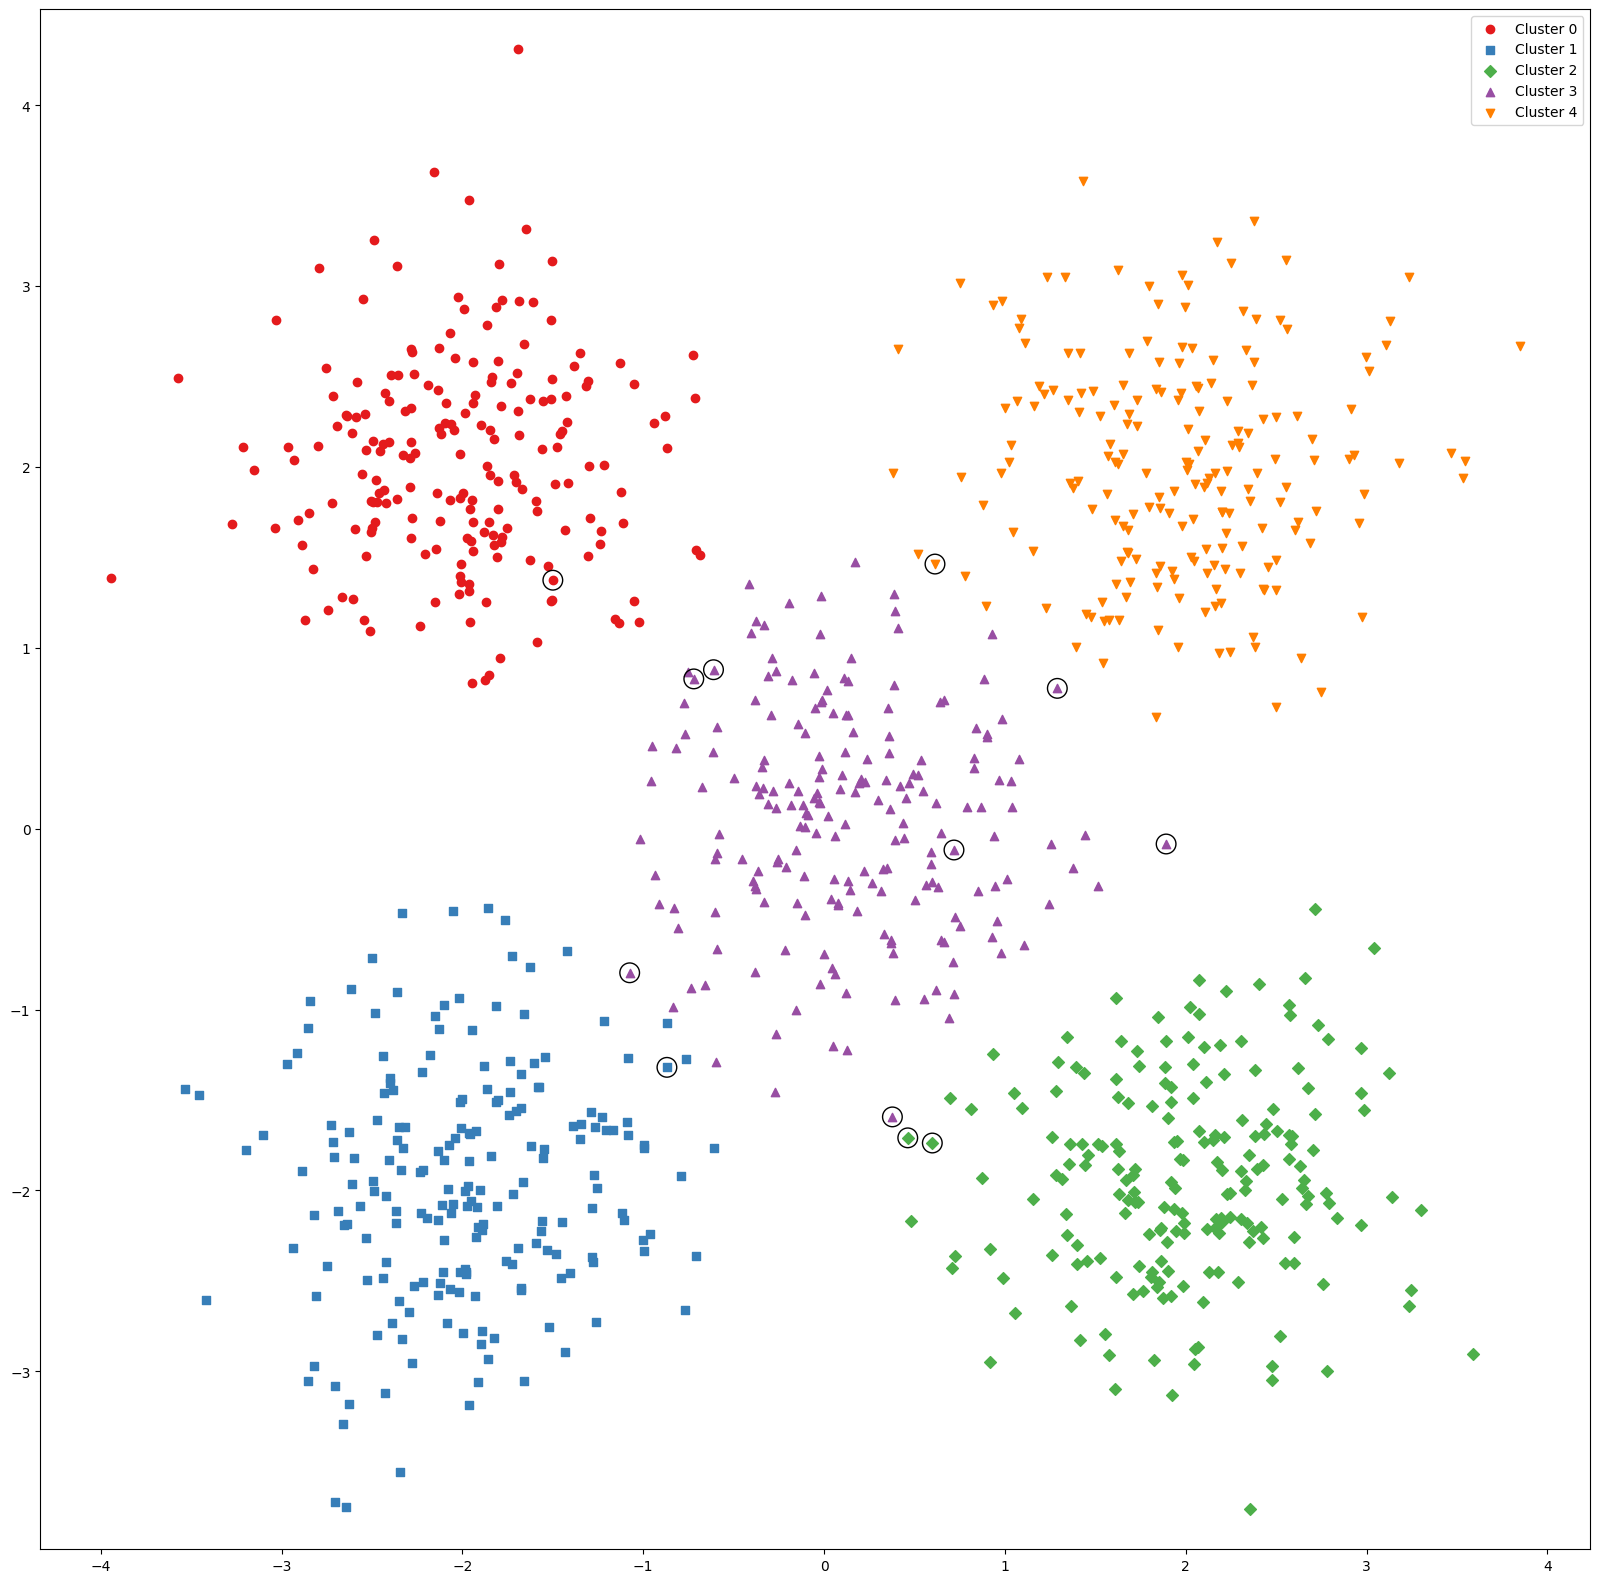

In [5]:
np.random.seed(0)
start = time()
y_pred = kmeans(X, 5)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

# Define a color and shape palette for plotting
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
shapes = ['o', 's', 'D', '^', 'v']

fig, axs = plt.subplots(1, figsize=(20, 20))

y_pred_aligned = -np.ones_like(y_pred)
for i in range(5):

    # assign cluster id to class label
    selected_objects = y_pred==i
    class_ = np.argmax(np.bincount(y[selected_objects]))
    y_pred_aligned[selected_objects] = class_

    cluster_i = X[selected_objects]
    axs.scatter(cluster_i[:, 0], cluster_i[:, 1], color=colors[i], marker=shapes[i], label=f'Cluster {i}')

    # assign cluster id to class label
    missclassifications = np.invert(np.logical_and(y_pred==i, y==class_))
    class_missclassifications = np.logical_and(missclassifications, selected_objects)

    cluster_fp = X[class_missclassifications]
    axs.scatter(cluster_fp[:, 0], cluster_fp[:, 1], s=200, facecolors='none', edgecolors='black')

axs.legend()
axs.axis('equal')
plt.show()

### 1.2: Quantitative Evaluation (2 Pts)

Looking at points is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance. In this task you will quantitatively analyse the predictions of the k-means clustering. To do this we will first calculate the accuracy of the approach and then we will calculate the confusion matrix to see which class is most likely confused with which. 

<img src="imgs/example_confusion.png" alt="Confusion Matrix" width="800" />

Now implement the functions `compute_accuracy()` and `compute_confusion_matrix()`. For reference the example results are provided, yours should be close, but don't have to match exactly.

In [6]:
def compute_accuracy(y_true, y_pred):
    """ Compute the accuracy of the clustering.
    Args:
        y_true - The ground truth. A array of size n_samples 
            where y_true[x] corresponds to the correct class for x.
        y_pred - The prediction. A array of size n_samples 
            where y_pred[x] corresponds to the predicted class for x.
    Returns:
        accuracy - The fraction of samples where y_true and y_pred agree. A
            bigger number is better, where 1.0 indicates a perfect clustering.
    """

    accuracy = None
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    true = 0 # how many predictions are correct

    # count correct predictions
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            true+=1

    # calculate accurarcy
    accuracy = true / len(y_true)
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    return accuracy

def compute_confusion_matrix(y_true, y_pred):
    """ Compute the confusion matrix for the clustering.
    Args:
        y_true - The ground truth. A array of size n_samples 
            where y_true[x] corresponds to the correct class for x.
        y_pred - The prediction. A array of size n_samples 
            where y_pred[x] corresponds to the predicted class for x.
    Returns:
        confusion_matrix - array-like of shape (n_classes, n_classes)
            The confusion matrix, where each element (i, j) represents the number of samples
            that belong to class i but were predicted as class j. n_classes == len(centers)
    Examples:
    ---------
    >>> y_true = [0, 1, 0, 1, 2, 2, 2]
    >>> y_pred = [0, 1, 1, 1, 2, 0, 2]
    >>> compute_confusion_matrix(y_true, y_pred)
    array([[1, 1, 0],
           [0, 2, 0],
           [1, 0, 2]])
    """

    confusion_matrix = None
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    # get size of confusion matrix
    size = len(np.unique(y_true))

    # create and add confusion matrix array
    confusion_matrix = np.zeros((size, size))

    # fill matrix
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]]+= 1
        
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    return confusion_matrix

In [7]:
acc = compute_accuracy(y, y_pred_aligned)
cm = compute_confusion_matrix(y, y_pred_aligned)

print(acc)
print(cm)

# 0.989
# [[198   0   2   0   0]
#  [  0 198   2   0   0]
#  [  1   0 195   2   2]
#  [  0   0   0 200   0]
#  [  0   0   2   0 198]]

0.988
[[198.   0.   2.   0.   0.]
 [  0. 199.   1.   0.   0.]
 [  1.   1. 195.   1.   2.]
 [  0.   0.   1. 199.   0.]
 [  0.   0.   3.   0. 197.]]


## Part 2: k-Means for CIFAR-10 (5pts)

In this part you will apply your k-means algorithm to the CIFAR-10 dataset. [Download](https://www.cs.toronto.edu/~kriz/cifar.html) and extract the *Python* version of the CIFAR10 dataset into a folder *outside* of the code folder. Read the website to understand which classes there are and how the data are structured. The code for loading train and test splits is given below; simply change the path to your data directory.


#### Functions for loading the CIFAR10 datast

In [8]:

def format_image(row):
  data = np.reshape(row, (32, 32, 3), order='F')  # row to 32x32x3
  data = np.transpose(data, (1, 0, 2))  # transpose x and y axis of image
  return data


def load_CIFAR10_batch(batch_path):
  """ load single batch of cifar """
  X_list = []
  Y_list = []
  try:
    with open(str(batch_path), 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        data_images = data_dict[b'data'] # 10000 x 3072

        for i, label in enumerate(data_dict[b'labels']):

            X_list.append(format_image(data_images[i]))
            Y_list.append(label)

        return np.stack(X_list), np.stack(Y_list)
  except:
    output = f'{batch_path} is not a directory or an expected file inside is missing.'
    raise ValueError(output)
  

def load_CIFAR10(data_path, n_per_class: int = None, shuffle: bool = False):

  X, Y= load_CIFAR10_batch(Path(data_path) / 'test_batch')
  if n_per_class is not None:
     X_list = []
     Y_list = []
     for i in range(10):
        mask = Y==i
        assert n_per_class <= mask.sum()
        X_list.append(X[mask][:n_per_class])
        Y_list.append(Y[mask][:n_per_class])
        
     X = np.concatenate(X_list)
     Y = np.concatenate(Y_list)
  
  if shuffle:
    idx_shuffled = np.array(range(X.shape[0]))
    np.random.shuffle(idx_shuffled)
    X = X[idx_shuffled]
    Y = Y[idx_shuffled]

  return X, Y




Change the `cifar10_dir` variable to your path, where you stored the CIFAR10 dataset and use the functions above to load images and their label from the CIFAR10 dataset.

We only use images from the *test_batch* of the CIFAR10 dataset as you can see in the function above. We are working with a balanced dataset since for each class we sample the same amount of samples. The number of samples per class can be specified with `n_per_class`. If you load 200 images per class the output of the following cell should be this:
```
Data shape:  (2000, 32, 32, 3)
Labels shape:  (2000,)
```

In [9]:
cifar10_dir = "..\\cifar-10-python\\cifar-10-batches-py"
X, Y= load_CIFAR10(cifar10_dir, 200)

# Checking the size of the training and testing data
print('Data shape: ', X.shape)
print('Labels shape: ', Y.shape)


# Data shape:  (2000, 32, 32, 3)
# Labels shape:  (2000,)

Data shape:  (2000, 32, 32, 3)
Labels shape:  (2000,)


#### Visualizing the CIFAR10 dataset

The image produced by the following code cell should look like this (note that the class images can vary since we select the indices for the plot randomly):

<img src="imgs/cifar10.png" alt="Gini Index" width="400" />

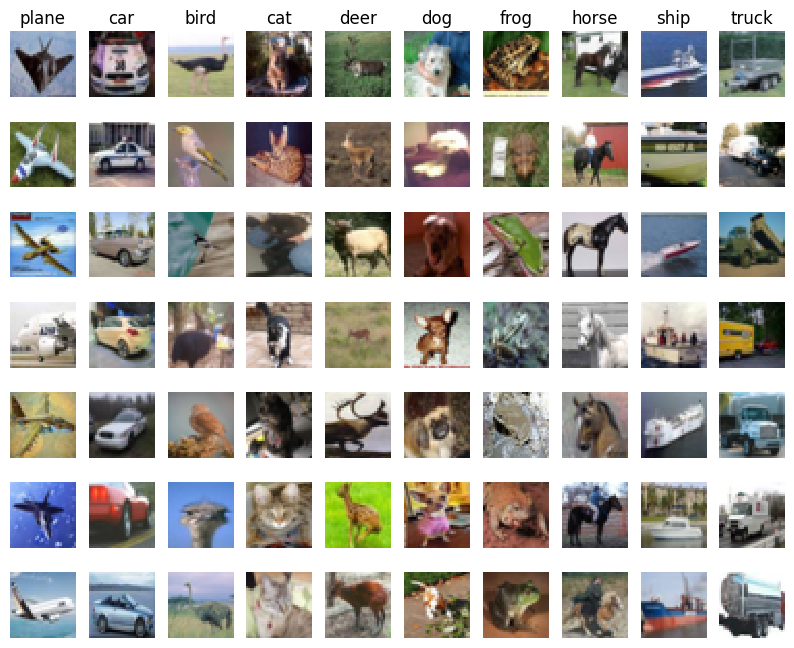

In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

### Apply the k-Means algorithm

The input feature vectors to our k-Means algorithm are the flattened images, meaning that each pixel is stacked on top of eachother. 
The shape of the dataset is then

```
Data shape: (2000, 3072)
```

In [11]:
# reshaping data and placing into rows - stack pixels onto eachother
X_flat = X.reshape(X.shape[0], -1) # (2000, 32x32x3)
print(f'Data shape: {X_flat.shape}')

# Data shape: (2000, 3072)

Data shape: (2000, 3072)


In [12]:
def apply_kmeans(input_feats, k=10, num_iters=200):

    Y_pred = kmeans(input_feats, k, num_iters)

    # map cluster ids to class ids
    Y_pred_aligned = -np.ones_like(Y_pred)
    for i in range(10):
        selected_objects = Y_pred==i
        class_ = np.argmax(np.bincount(Y[selected_objects]))
        Y_pred_aligned[selected_objects] = class_
    return Y_pred_aligned


Use the `apply_kmeans` function to compare the clustering results on CIFAR10 using the raw inputs vs. the standardized inputs. 

The results for 200 interations should be something close to:
```
Accuracy - raw: 0.146
Accuracy - std: 0.2275
```
You see that standadization makes a big difference however the results are not great in general. Feel free to try different number of iterations. 
It seems that simply stacking pixels on top of each other are not good features. In the next exercise (exercise 4) we will start with Neural Networks which are great feature extractors that can be trained and learn in contrast to raw features or hand crafted features you learnt in the lecture.

In [13]:
iterations = 200
# Standardize the input features, do not use functions from python library
X_std = (X_flat - np.mean(X_flat, axis=0)) / np.std(X_flat, axis=0) # z = (x - μ) / σ

pred_raw = apply_kmeans(X_flat, k=10, num_iters=iterations)
acc_raw = compute_accuracy(Y, pred_raw)
print(f"Accuracy - raw: {acc_raw}")

pred_std = apply_kmeans(X_std, k=10, num_iters=iterations)
acc_std = compute_accuracy(Y, pred_std)
print(f"Accuracy - std: {acc_std}")


Accuracy - raw: 0.1525
Accuracy - std: 0.2295
